<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    del Mini-Challenge 2 <br> 
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>


Ziel:  
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach. 

Beispiel:  
Implementiere, trainiere und validiere ein Deep Learning Modell für Image Captioning wie beschrieben im Paper Show and Tell.

Zeitlicher Rahmen:  
Wird beim Schritt 1 verbindlich festgelegt.

Beurteilung:  
Beurteilt wird auf Basis des abgegebenen Notebooks:  
•	Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung.  
•	Klare, gut-strukturierte Umsetzung.   
•	Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut kommentierten Plots und Tabellen.  
•	Vernünftiger Umgang mit (Computing-)Ressourcen.  
•	Verständliche Präsentation der Ergebnisse.  

Referenzen, Key Words  
•	Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: [Link](https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s)      
•	Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise ResNet, GoogLeNet, EfficientNet oder ähnlich Transfer-Learning.  
•	Seq2Seq Models bekannt für Sprach-Übersetzung. 

Daten:   
•	Gemäss Vereinbarung (für Captioning: [Flickr8k-Daten](https://www.kaggle.com/adityajn105/flickr8k/activity)).

•	Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll.
 

# 1 Setup und Imports

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
os.chdir('../')

In [2]:
import tqdm 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Torch
import torch
print(torch.__version__)
#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader

from src.gpu_setup import DeviceSetup


1.13.1+cu116


In [3]:
device_setup = DeviceSetup(seed=42)
device_setup.setup()

Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


---

# 2 Daten
Wir erkennen bei der Spalte *image*, das ein jpg. Bilddatei mehrere *catpion* hat.

Bei der Visualisierung der Bilder erkenne wir:
- Personen oder Tiere
- Unterschiedliche Grössen
- Unterschiedliche Auflösung


In [4]:
class DataExplorer:
    def __init__(self, image_path, captions_path):
        self.image_path = image_path
        self.data = pd.read_csv(captions_path)


    def _get_image_unique(self):
        """
        This method returns a list of unique image IDs.
        """
        image_unique = self.data['image'].unique()
        return image_unique
    
    def _get_word_counts(self):
        """
        This method returns a list of the number of words per caption.
        """
        word_counts = self.data['caption'].apply(str.split).apply(len)
        return word_counts
    
    def _read_image(self, image_id):
        """
        This method reads an image from a specific path and returns the image object.
        """
        image = Image.open(self.image_path + "/" + image_id)
        return image

    def _get_captions(self, image_id):
        """
        This method retrieves the captions associated with an image ID from the data dictionary.
        """
        captions = []
        for i in range(len(self.data)):
            if self.data['image'][i] == image_id:
                captions.append(self.data['caption'][i])
        captions = '\n'.join(captions)
        return captions

    def plot_n_m_image_caption(self, n, m):
        """
        This method plots a grid of n x m images along with their captions.
        """
        image_unique = self._get_image_unique()
        fig, ax = plt.subplots(n, m, figsize=(16, 20))
        for i in range(n):
            for j in range(m):
                index = np.random.randint(0, len(image_unique))
                image_id = image_unique[index]
                image = self._read_image(image_id)
                captions = self._get_captions(image_id)
                ax[i, j].imshow(np.asarray(image))
                ax[i, j].set_title(captions)
        plt.tight_layout()
        plt.show()

    def plot_image_size(self):
        """
        This method plots a grid of n x m images along with their captions.
        """
        image_unique = self._get_image_unique()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        # set range of x and y axis
        ax.set_xlabel('width of image')
        ax.set_ylabel('height of image')
        for i in range(len(image_unique)):
            image_id = image_unique[i]
            image = self._read_image(image_id)
            width, height = image.size
            ax.scatter(width, height)
        ax.set_title('Distribution size of images')
        plt.tight_layout()
        plt.show()

    # plot caption distribution word length
    def plot_caption_distribution(self):
        """
        This method plots the distribution of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        plt.figure(figsize=(12, 8))
        plt.hist(word_counts, bins=25, color = 'limegreen', edgecolor='black', linewidth=1.2)
        plt.title("Distribution of Number of Words per Caption")
        plt.xlabel("Number of Words")
        plt.ylabel("Frequency")
        plt.show()

    # get statistical summary of caption distribution word length
    def get_caption_distribution(self):
        """
        This method prints the statistical summary of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        print(word_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

    def plot_caption_ecdf(self):
        """
        This method plots the ECDF of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        word_counts_sorted = word_counts.sort_values()
        y = np.arange(1, len(word_counts_sorted) + 1) / len(word_counts_sorted)  
        plt.figure(figsize=(12, 8))
        plt.plot(word_counts_sorted, y)
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.axvline(x=19, color='r', linestyle='-')
        plt.xticks(np.arange(np.min(word_counts_sorted), np.max(word_counts_sorted), 1.0))
        plt.title("ECDF of Number of Words per Caption")
        plt.xlabel("Number of Words")
        plt.ylabel("Proportion")
        plt.show()

    # plot most commen words
    def plot_most_common_words(self):
        """
        This method plots the most common words in the captions.
        """
        from collections import Counter
        word_counts = self.data['caption'].apply(str.split).apply(Counter).sum()
        word_counts = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
        word_counts.columns = ['word', 'count']
        word_counts = word_counts.sort_values(by='count', ascending=False)
        plt.figure(figsize=(12, 8))
        plt.bar(word_counts['word'][:20], word_counts['count'][:20], color = 'limegreen', edgecolor='black', linewidth=1.2)
        plt.title("Most Common Words in Captions")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.show()

In [34]:
image_path = "data/Flickr8K/images/"
captions_path = "data/Flickr8K/captions.txt"

flicker_data_explorer = DataExplorer(image_path, captions_path)
flicker_data = flicker_data_explorer.data

## 2.1 Dataframe

In [41]:
flicker_data

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
40450           A man in a pink shirt climbs a rock face   
40451           A man is rock climbing high in the air .   
40452  A person in a red shirt climbing up a rock fac...   
40453                    A rock climber in a red shirt .   
40454  A rock climber practices on a rock climbing wa...   

                                       tokenized_caption  
0      [<sos>, A, child, in, a, pink, dress, is, clim...  
1      [<sos>, A, girl, going, into, a, wooden, build...  
2      [<sos>, A, little, girl, climbing, into, a, wo...  
3      [<sos>, A, little, girl, climbing, the, stairs...  
4      [<sos>, A, little, girl, in, a, pink, dress, g...  
...                                                  ...  
40450  [<sos>, A, man, in, a, pink, shirt, climbs, a,...  
40451  [<sos>, A, man, is, rock, climbing, high, in, ...  
40452  [<sos>, A, person, in, a, red, shirt, climbing...  
40453  [<sos>, A, rock, climber, in, a, red, shirt, ....  
40454  [<sos>, A, rock, climber, practices, on, a, ro...  

[40455 rows x 3 columns]

## 2.2 Visualisierungen der Bilder

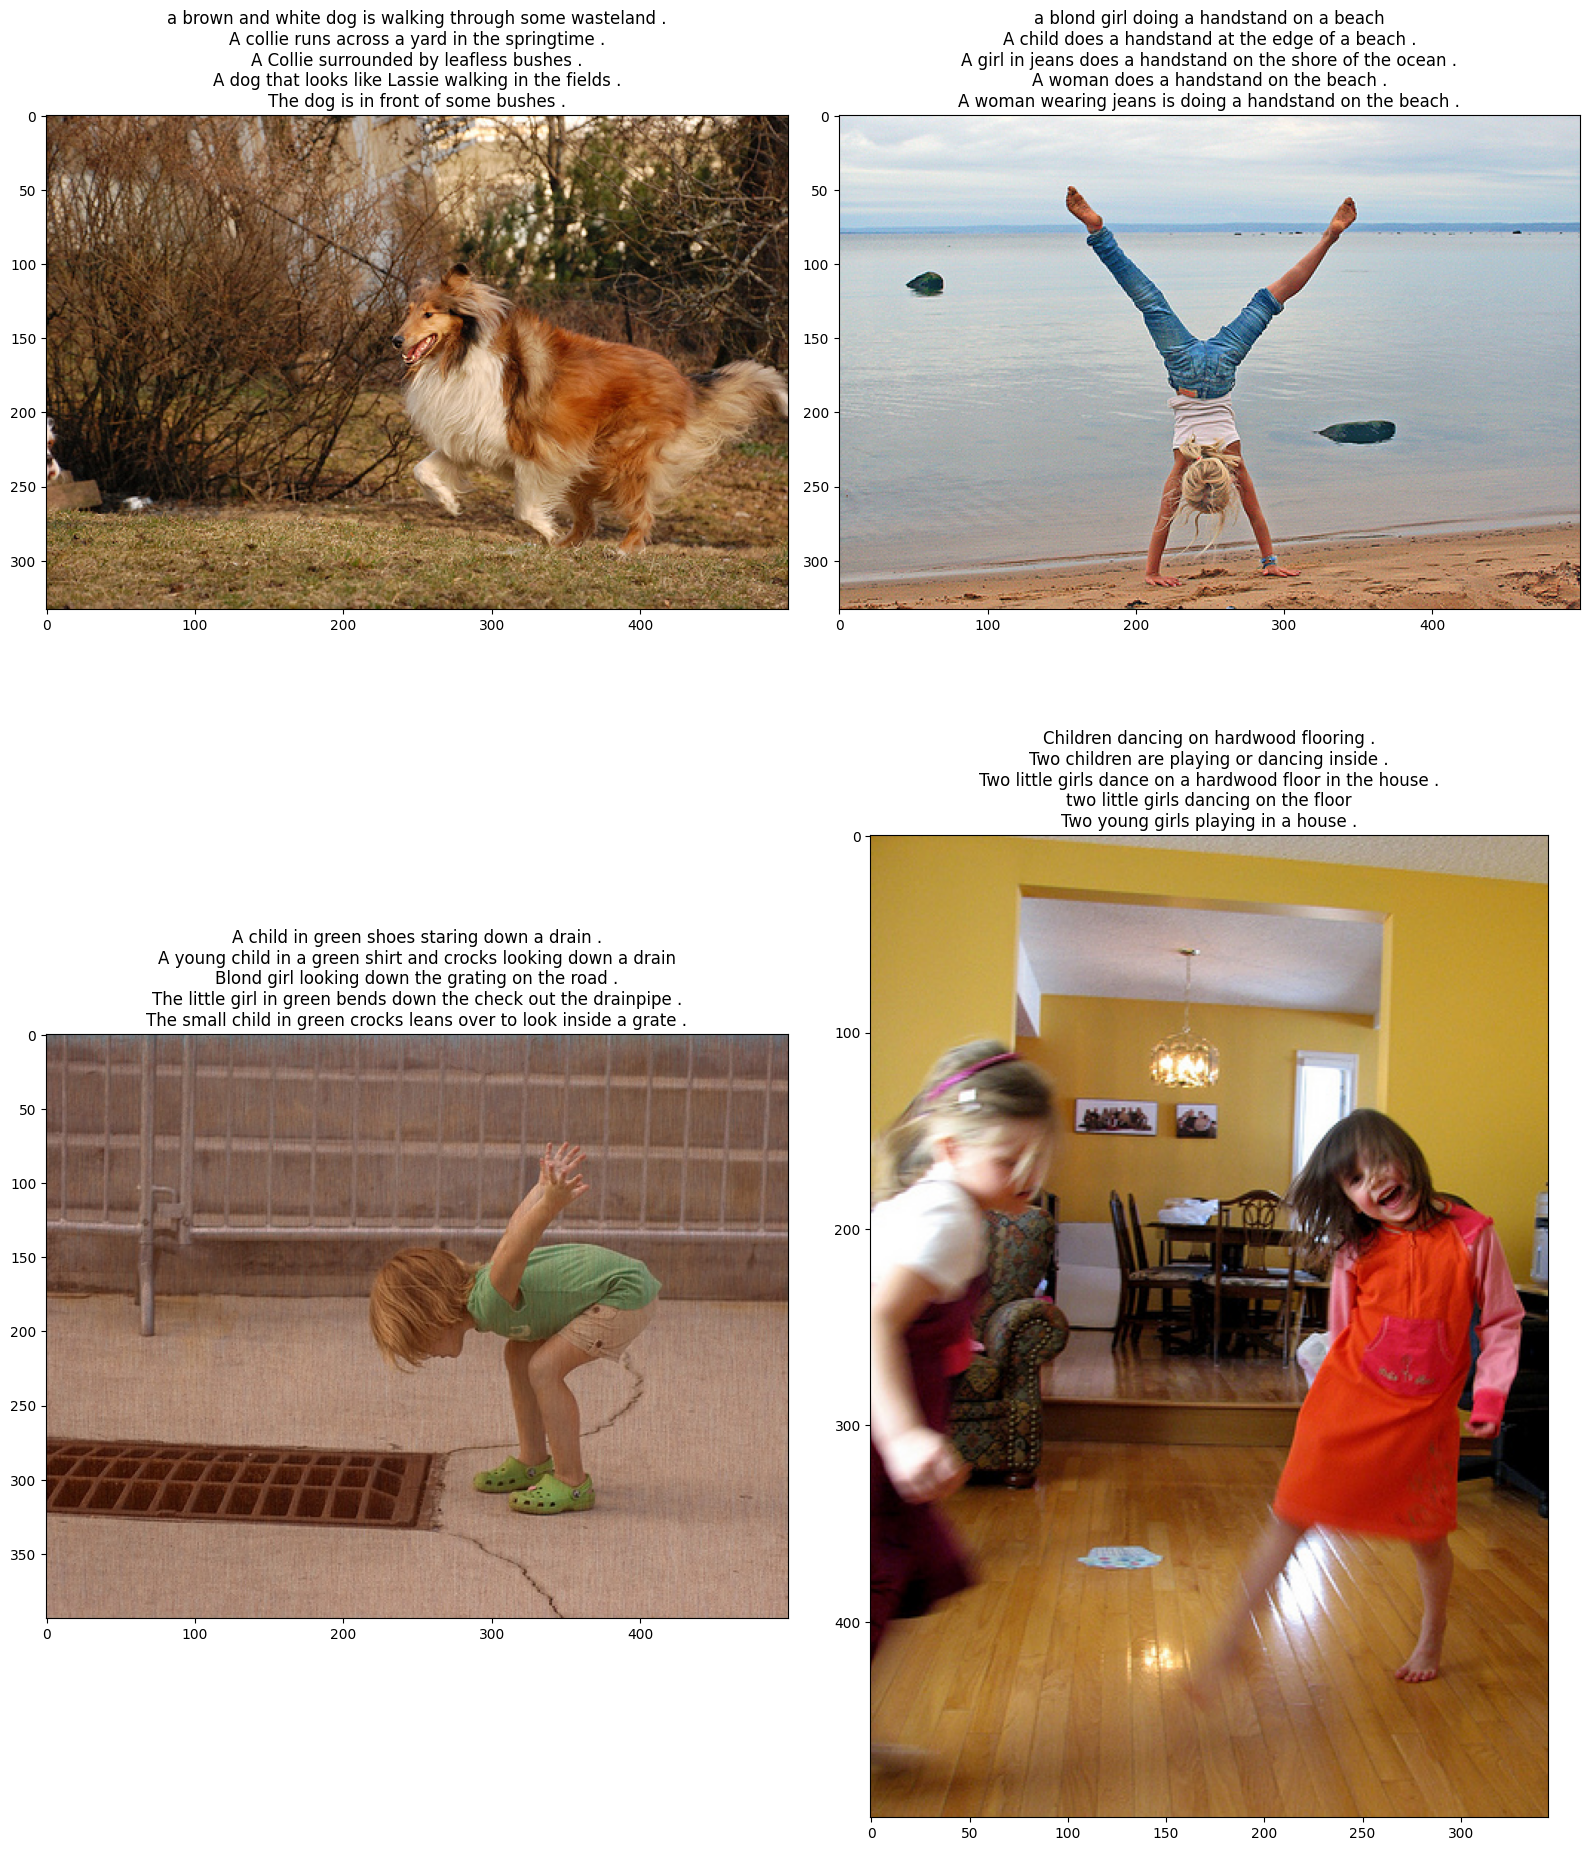

In [6]:
flicker_data.plot_n_m_image_caption(2, 2)

## 2.3 Grössen der Bilder

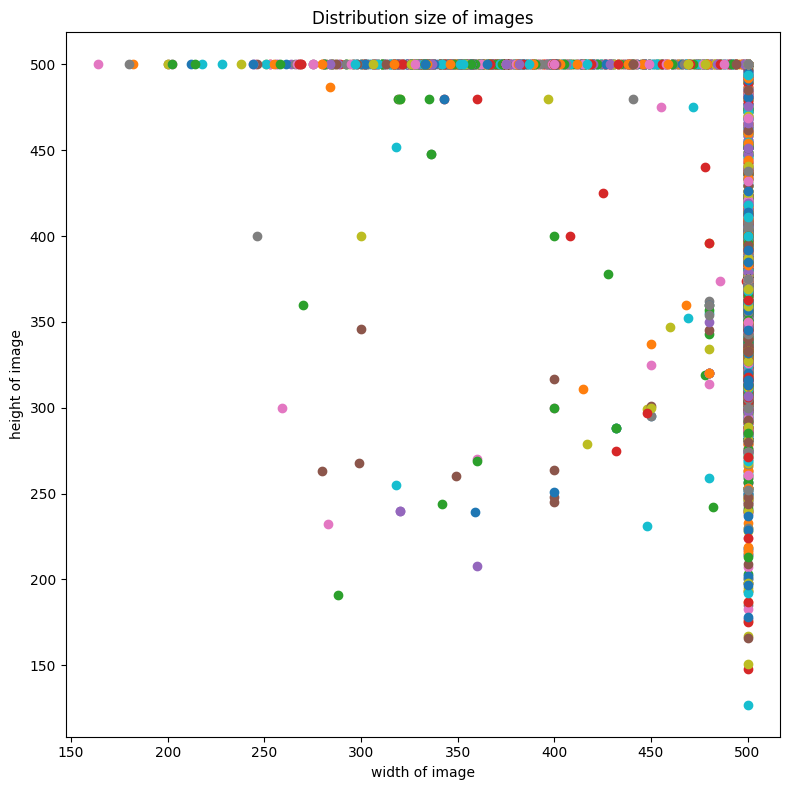

In [7]:
flicker_data.plot_image_size()

## 2.4 Caption Länge

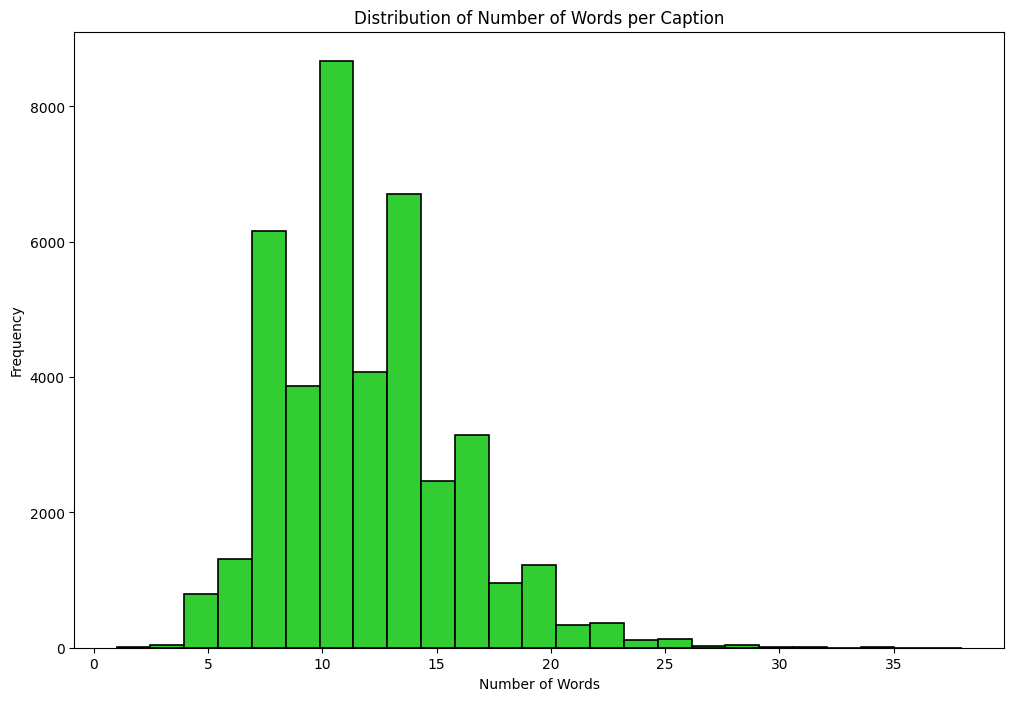

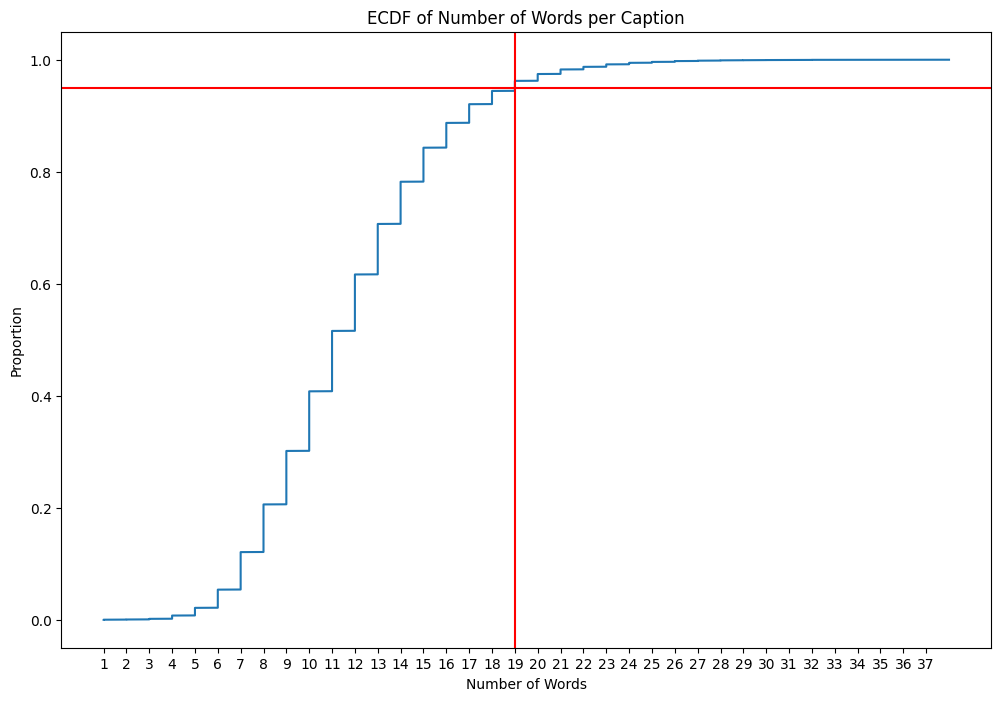

count    40455.000000
mean        11.782598
std          3.885152
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
95%         19.000000
max         38.000000
Name: caption, dtype: float64


In [8]:
flicker_data.plot_caption_distribution()
flicker_data.plot_caption_ecdf()
flicker_data.get_caption_distribution()

## 2.5 Häufigste Wörter

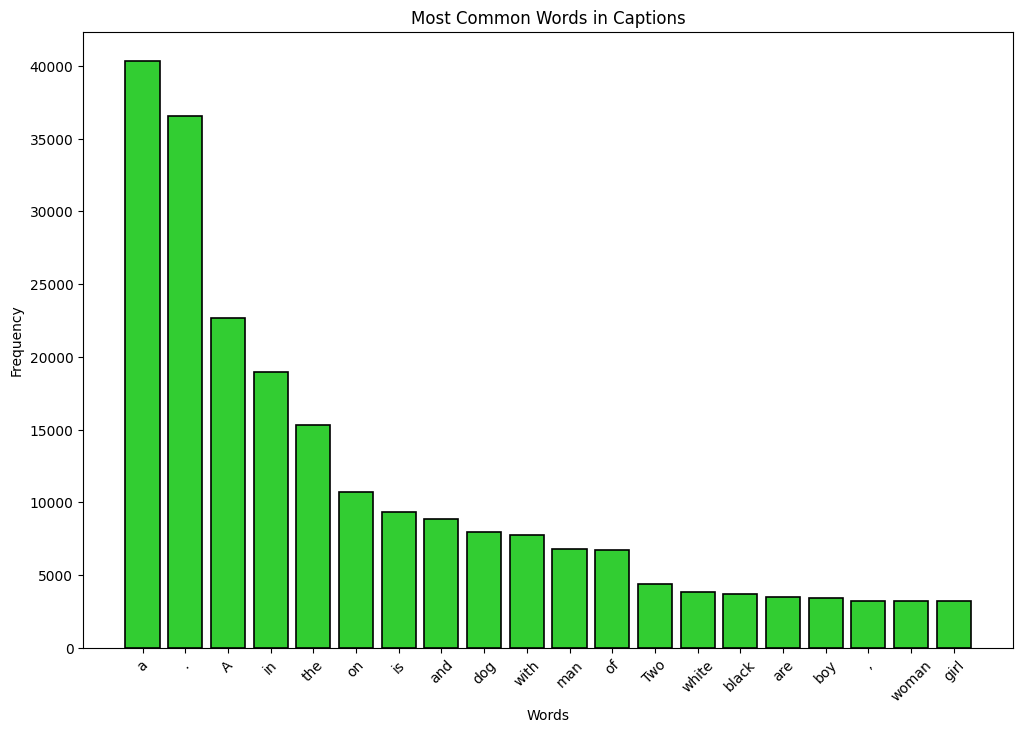

In [9]:
flicker_data.plot_most_common_words()

---

# 3 Preprocessing der Bilder

Wir werden Die Bilder wie folgt vorbereiten, damit das Model die Bilder verarbeiten kann: 

`ToPILImage()`: Dieser Schritt konvertiert das Eingabebild in ein PIL (Python Imaging Library) Bildformat. Dies ist erforderlich, wenn das Eingabebild nicht bereits im PIL-Format vorliegt.

`CenterCrop((500, 500))`: Hier wird das Bild auf eine Größe von 500x500 Pixel zentriert zugeschnitten. Dies ist nützlich, um das Bild auf eine bestimmte Größe zu bringen und sicherzustellen, dass wichtige Merkmale in der Mitte erhalten bleiben.

`Resize((224, 224))`: Das Bild wird auf eine Größe von 224x224 Pixel skaliert. Dies ist eine häufig verwendete Größe für viele neuronale Netzwerke, insbesondere in der Bildklassifikation, wie z.B. Convolutional Neural Networks (CNNs).

`ToTensor()`: Hier wird das Bild in einen PyTorch-Tensor konvertiert. Die meisten neuronalen Netzwerke in PyTorch und anderen Frameworks arbeiten mit Tensoren als Eingabe.

`Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Diese Transformation normalisiert die Pixelwerte des Bildes. Dies ist wichtig, um sicherzustellen, dass die Werte im Eingangsbild in einem bestimmten Bereich liegen. Die angegebenen Mittelwerte und Standardabweichungen sind typische Werte für die Normalisierung von Bildern, die auf dem ImageNet-Datensatz trainiert wurden.

In [10]:
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, ToPILImage, Normalize

# Transformations for the image
image_transformations = Compose([
    ToPILImage(),
    CenterCrop((500, 500)),
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229,0.224,0.225])
])


---

# 4 PreProcessing von Captions

In [46]:
import nltk

# define special tokens
start_token = "<sos>"
stop_token = "<eos>"
unknown_token = "<unk>"
padding_token = "<pad>"

# defline max length of caption
max_length = 20

def create_vocab(dataframe, caption_column, start_token, stop_token, unknown_token, padding_token):
    """
    Create a vocabulary from a DataFrame containing captions.
    Args:
        dataframe (pandas.DataFrame): A DataFrame containing caption data.
        caption_column (str): The name of the column in the DataFrame that contains captions.
    Returns:
        list: A vocabulary list that includes special tokens (start, stop, unknown, padding)
              and all unique words from the captions in the specified column.
    """
    # Join all the captions in the specified column of the DataFrame
    all_captions = " ".join(dataframe[caption_column].values)
    # Tokenize the joined captions into words and convert them to lowercase
    vocabulary = nltk.tokenize.word_tokenize(all_captions.lower())
    # Add special tokens to the vocabulary
    vocabulary = [start_token, stop_token, unknown_token, padding_token] + vocabulary
    # Return the resulting vocabulary
    return vocabulary

vocabulary = create_vocab(dataframe=flicker_data, caption_column="caption", 
                          start_token=start_token, stop_token=stop_token, 
                          unknown_token=unknown_token, padding_token=padding_token)

def caption_to_tokens(dataframe, caption_column, start_token, stop_token):
    """
    Preprocess captions in a DataFrame by tokenizing and adding start and stop tokens.
    Args:
        dataframe (pandas.DataFrame): A DataFrame containing caption data.
        caption_column (str): The name of the column in the DataFrame that contains captions.
    Returns:
        pandas.DataFrame: The input DataFrame with an additional "tokenized_caption" column 
                          containing tokenized captions with start and stop tokens added.
    """
    start_token = "<sos>"
    stop_token = "<eos>"
    # Convert captions to lowercase
    dataframe["tokenized_caption"] = dataframe[caption_column].apply(lambda x: x.lower())
    # Split caption into tokens
    dataframe["tokenized_caption"] = dataframe[caption_column].apply(lambda x: x.split())
    # Add start token at the beginning
    dataframe["tokenized_caption"] = dataframe["tokenized_caption"].apply(lambda x: [start_token] + x)
    # Add stop token at the end
    dataframe["tokenized_caption"] = dataframe["tokenized_caption"].apply(lambda x: x + [stop_token])
    return dataframe

flicker_data_tokenized = caption_to_tokens(dataframe=flicker_data, caption_column="caption", start_token=start_token, stop_token=stop_token)
display(flicker_data_tokenized)

def tokens_to_caption(tokens, vocabulary, padding_token, max_length):
    """
    Converts a list of tokens into a human-readable caption, handling unknown words, padding, and maximum length.
    Args:
        tokens (list): List of tokens representing a caption.
        vocabulary (list): List of known vocabulary words.
        padding_token (str): The padding token.
        max_length (int): The maximum allowed length for the caption.
    Returns:
        str: Human-readable caption.
    """
    # Lower-case every token in the list
    tokens = [token.lower() for token in tokens]
    # Remove start and stop tokens
    tokens = [token for token in tokens if token not in [start_token, stop_token]]
    # Replace unknown tokens with "<unk>"
    tokens = [token if token in vocabulary else unknown_token for token in tokens]
    # Exclude padding tokens
    tokens = [token for token in tokens if token != padding_token]
    # Truncate the caption to the maximum length
    tokens = tokens[:max_length]
    # Join the tokens to create the caption
    caption = " ".join(tokens)
    return caption

sample_tokens_unkown = ["<sos>", "a", "cat", "si","is", "sitting", "ben", "<pad>", "the", "mat", "<pad>", "tran", "<eos>"]
sample_tokens_kown = flicker_data_tokenized["tokenized_caption"][0]

caption_unkown = tokens_to_caption(sample_tokens_unkown, vocabulary, padding_token, max_length)
caption_kown = tokens_to_caption(sample_tokens_kown, vocabulary, padding_token, max_length)

print(caption_unkown)
print(caption_kown)


image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
40450           A man in a pink shirt climbs a rock face   
40451           A man is rock climbing high in the air .   
40452  A person in a red shirt climbing up a rock fac...   
40453                    A rock climber in a red shirt .   
40454  A rock climber practices on a rock climbing wa...   

                                       tokenized_caption  
0      [<sos>, A, child, in, a, pink, dress, is, clim...  
1      [<sos>, A, girl, going, into, a, wooden, build...  
2      [<sos>, A, little, girl, climbing, into, a, wo...  
3      [<sos>, A, little, girl, climbing, the, stairs...  
4      [<sos>, A, little, girl, in, a, pink, dress, g...  
...                                                  ...  
40450  [<sos>, A, man, in, a, pink, shirt, climbs, a,...  
40451  [<sos>, A, man, is, rock, climbing, high, in, ...  
40452  [<sos>, A, person, in, a, red, shirt, climbing...  
40453  [<sos>, A, rock, climber, in, a, red, shirt, ....  
40454  [<sos>, A, rock, climber, practices, on, a, ro...  

[40455 rows x 3 columns]

a cat <unk> is sitting <unk> the mat <unk>
a child in a pink dress is climbing up a set of stairs in an entry way .


---

# 5 Word Embedding


In [ ]:
# Embedding the tokenized_caption

---

# 6 Data Preparation

## 6.1 Train-Validation-Test Split

In [62]:
from sklearn.model_selection import train_test_split
# get all unique images
images = flicker_data_tokenized["image"].unique()

# Split the images into train, validation, and test sets Train/Val/Test split (60/20/20)
train_images, val_test_images = train_test_split(images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

# Then, filter the data based on the split sets
train_df = flicker_data_tokenized[flicker_data_tokenized["image"].isin(train_images)]
val_df = flicker_data_tokenized[flicker_data_tokenized["image"].isin(val_images)]
test_df = flicker_data_tokenized[flicker_data_tokenized["image"].isin(test_images)]

# display the data
display("train_data", train_df)
display("val_data", val_df)
display("test_data", test_df)

'train_data'

image  \
5      1001773457_577c3a7d70.jpg   
6      1001773457_577c3a7d70.jpg   
7      1001773457_577c3a7d70.jpg   
8      1001773457_577c3a7d70.jpg   
9      1001773457_577c3a7d70.jpg   
...                          ...   
40440    99679241_adc853a5c0.jpg   
40441    99679241_adc853a5c0.jpg   
40442    99679241_adc853a5c0.jpg   
40443    99679241_adc853a5c0.jpg   
40444    99679241_adc853a5c0.jpg   

                                                 caption  \
5             A black dog and a spotted dog are fighting   
6      A black dog and a tri-colored dog playing with...   
7      A black dog and a white dog with brown spots a...   
8      Two dogs of different breeds looking at each o...   
9        Two dogs on pavement moving toward each other .   
...                                                  ...   
40440  A grey bird stands majestically on a beach whi...   
40441    A large bird stands in the water on the beach .   
40442  A tall bird is standing on the sand beside the...   
40443       A water bird standing at the ocean 's edge .   
40444  A white crane stands tall as it looks out upon...   

                                       tokenized_caption  
5      [<sos>, A, black, dog, and, a, spotted, dog, a...  
6      [<sos>, A, black, dog, and, a, tri-colored, do...  
7      [<sos>, A, black, dog, and, a, white, dog, wit...  
8      [<sos>, Two, dogs, of, different, breeds, look...  
9      [<sos>, Two, dogs, on, pavement, moving, towar...  
...                                                  ...  
40440  [<sos>, A, grey, bird, stands, majestically, o...  
40441  [<sos>, A, large, bird, stands, in, the, water...  
40442  [<sos>, A, tall, bird, is, standing, on, the, ...  
40443  [<sos>, A, water, bird, standing, at, the, oce...  
40444  [<sos>, A, white, crane, stands, tall, as, it,...  

[24270 rows x 3 columns]

'val_data'

image  \
40     1015118661_980735411b.jpg   
41     1015118661_980735411b.jpg   
42     1015118661_980735411b.jpg   
43     1015118661_980735411b.jpg   
44     1015118661_980735411b.jpg   
...                          ...   
40425   989851184_9ef368e520.jpg   
40426   989851184_9ef368e520.jpg   
40427   989851184_9ef368e520.jpg   
40428   989851184_9ef368e520.jpg   
40429   989851184_9ef368e520.jpg   

                                                 caption  \
40     A boy smiles in front of a stony wall in a city .   
41     A little boy is standing on the street while a...   
42                   A young boy runs aross the street .   
43     A young child is walking on a stone paved stre...   
44     Smiling boy in white shirt and blue jeans in f...   
...                                                  ...   
40425          A black dog has a dumbbell in his mouth .   
40426  A black dog has a dumbbell in his mouth lookin...   
40427  A black dog holding a weight in its mouth stan...   
40428  A black dog holds a small white dumbbell in it...   
40429  The black dog has a toy in its mouth and a per...   

                                       tokenized_caption  
40     [<sos>, A, boy, smiles, in, front, of, a, ston...  
41     [<sos>, A, little, boy, is, standing, on, the,...  
42     [<sos>, A, young, boy, runs, aross, the, stree...  
43     [<sos>, A, young, child, is, walking, on, a, s...  
44     [<sos>, Smiling, boy, in, white, shirt, and, b...  
...                                                  ...  
40425  [<sos>, A, black, dog, has, a, dumbbell, in, h...  
40426  [<sos>, A, black, dog, has, a, dumbbell, in, h...  
40427  [<sos>, A, black, dog, holding, a, weight, in,...  
40428  [<sos>, A, black, dog, holds, a, small, white,...  
40429  [<sos>, The, black, dog, has, a, toy, in, its,...  

[8090 rows x 3 columns]

'test_data'

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
40450           A man in a pink shirt climbs a rock face   
40451           A man is rock climbing high in the air .   
40452  A person in a red shirt climbing up a rock fac...   
40453                    A rock climber in a red shirt .   
40454  A rock climber practices on a rock climbing wa...   

                                       tokenized_caption  
0      [<sos>, A, child, in, a, pink, dress, is, clim...  
1      [<sos>, A, girl, going, into, a, wooden, build...  
2      [<sos>, A, little, girl, climbing, into, a, wo...  
3      [<sos>, A, little, girl, climbing, the, stairs...  
4      [<sos>, A, little, girl, in, a, pink, dress, g...  
...                                                  ...  
40450  [<sos>, A, man, in, a, pink, shirt, climbs, a,...  
40451  [<sos>, A, man, is, rock, climbing, high, in, ...  
40452  [<sos>, A, person, in, a, red, shirt, climbing...  
40453  [<sos>, A, rock, climber, in, a, red, shirt, ....  
40454  [<sos>, A, rock, climber, practices, on, a, ro...  

[8095 rows x 3 columns]

## 6.2 Data Loader

In [69]:
from torch.utils.data import Dataset, DataLoader
from multiprocessing import cpu_count


train_data = 0
val_data = 0 
test_data = 0

train_loader = DataLoader(train_data, batch_size=2, pin_memory=True, num_workers=cpu_count(), shuffle=True)
val_loader = DataLoader(val_data, batch_size=2, pin_memory=True, num_workers=cpu_count(), shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, pin_memory=True, num_workers=cpu_count(), shuffle=True)



--- 

# 7 CNN Encoder

In [65]:
# load Resnet18 model in this class 
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class EncoderCNN(nn.Module):
    def __init__(self, embedding_dim):
        super(EncoderCNN, self).__init__()
        self.embedding_dim = embedding_dim
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Use ResNet-18 with pre-trained weights

        # Remove the last classification layer
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        # Add own linear layer and batch normalization
        self.linear = nn.Linear(resnet.fc.in_features, self.embedding_dim)
        self.bn = nn.BatchNorm1d(self.embedding_dim, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.feature_extractor(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    

---

# 8 LSTM Decoder

In [66]:
# load DecoderLSTM model 
class DecoderLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()
        # define the properties
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        # define the layers
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        # initialize weights
        self.init_weights()

    def forward(self, features, captions):
        """
        Decode feature vectors and generates captions.
        Args:
            features (torch.Tensor): Tensor of extracted feature vectors from images.
            captions (torch.Tensor): Tensor of captions.
        Returns:
            torch.Tensor: Tensor of predicted captions.
        """
        # Remove end token from captions
        captions = captions[:, :-1]
        # Embed the captions
        embeddings = self.embed(captions)
        # Concatenate the feature vectors and embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        # Pass the embeddings through the LSTM cells
        hiddens, _ = self.lstm(embeddings)
        # Reshape outputs to be (batch_size * sequence_length, hidden_size)
        outputs = hiddens.reshape(-1, hiddens.size(2))
        # Pass the outputs through the linear layer
        outputs = self.linear(outputs)
        return outputs

    def sample(self, features, states=None):
        """
        Generate captions for given image features using greedy search.
        Args:
            features (torch.Tensor): Tensor of extracted feature vectors from images.
            states (tuple, optional): Initial hidden states for the LSTM.
        Returns:
            torch.Tensor: Tensor of predicted captions.
        """
        # Initialize caption with start token
        caption = torch.Tensor([[vocabulary.index(start_token)]]).long()
        # Move caption tensor to GPU if CUDA is available
        if torch.cuda.is_available():
            caption = caption.cuda()
        # Initialize LSTM hidden states
        if states is None:
            states = (torch.zeros(self.num_layers, 1, self.hidden_size),
                      torch.zeros(self.num_layers, 1, self.hidden_size))
            if torch.cuda.is_available():
                states = (states[0].cuda(), states[1].cuda())
                
        # Construct the caption word by word
        words = []
        for i in range(max_length):
            # Embed the last predicted word for the current timestep
            embeddings = self.embed(caption)
            # Pass the embeddings through the LSTM cells and get hidden states
            hiddens, states = self.lstm(embeddings, states)
            # Reshape outputs to be (batch_size * sequence_length, hidden_size)
            outputs = hiddens.reshape(-1, hiddens.size(2))
            # Pass the outputs through the linear layer
            outputs = self.linear(outputs)
            # Get the index of the predicted word with the highest score
            predicted = outputs.argmax(1)
            # Append the predicted word to the caption
            words.append(predicted.item())
            # Break if stop token is predicted
            if vocabulary[predicted.item()] == stop_token:
                break
            # Append the predicted word to the caption
            caption = predicted.unsqueeze(0)

        return [vocabulary[i] for i in words]
    

---

# 9 Encoder-Decoder Architektur

In [ ]:
# create encoder and decoder
encoder = EncoderCNN(embedding_dim=10)
decoder = DecoderLSTM(embedding_dim=10, hidden_size=20, vocab_size=len(vocabulary), num_layers=1)







---

# 10 Evalierung